# Identify Object Positions in Images - YOLO vs VLM 

---

Consider the image: `/images/table_scene.jpeg`.

### TASK
Detect the cup on the table and identify it visually by **drawing a bounding box around it on the image itself**.  
You can do this using the provided `utils` functions, or by writing your own.

### Models to Compare
Compare the performance of these three models:

1. **YOLO**
2. **GPT-4.1-mini**
3. **Gemini 2.5-flash**

### Notes
Depending on your prompt choice and the model’s output format, you may need to:

- update the `utils` functions, or  
- adapt your code to make it compatible (e.g., **parsing outputs** that come back as text vs JSON).

---


### Utils 
Some of the utils are taken and modified for the purpose of the exercise from 
https://colab.research.google.com/drive/1eDvf_Ky9jLOZFShgHrm4GI-wkAaQnue6?usp=sharing#scrollTo=wizbxA1lm-Tj
https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Object_detection.ipynb#scrollTo=245bc92a470f


In [2]:
import json
import re
from PIL import Image, ImageDraw
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

#this function is needed to plot bounding boxes on images 
def plot_bounding_boxes(im, positions):
    """
    Plots bounding boxes on an image with markers for each noun phrase, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        noun_phrases_and_positions: A list of tuples containing the noun phrases
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    ] + additional_colors

    # Iterate over the noun phrases and their positions
    for i, ((y1, x1, y2, x2)) in enumerate(positions):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        #draw.text((abs_x1 + 8, abs_y1 + 6), noun_phrase, fill=color)

    # Display the image
    img.show()

# if the boxes coordinates are output not as json but as text, should be parsed first
def parse_list_boxes(text):
  result = []
  for line in text.strip().splitlines():
    # Extract the numbers from the line, remove brackets and split by comma
    try:
      numbers = line.split('[')[1].split(']')[0].split(',')
    except:
      numbers =  line.split('- ')[1].split(',')

    # Convert the numbers to integers and append to the result
    result.append([int(num.strip()) for num in numbers])

  return result

{"detections":[{"class":"coffee cup","xmin":570,"xmax":820,"ymin":460,"ymax":720},{"class":"coffee cup","xmin":320,"xmax":570,"ymin":430,"ymax":700}]}
(612, 408)


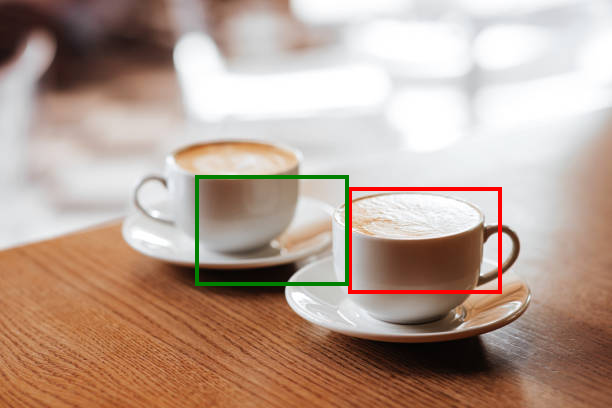

In [47]:
import openai
from dotenv import load_dotenv  
import base64
import json
import textwrap

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

load_dotenv()
openAIclient = openai.OpenAI()

# Path to your image
img = "images/coffee_cups.jpg"

completion = openAIclient.chat.completions.create(
    model="gpt-4.1-mini",
    messages=[
        {"role": "system", "content": "you are a careful observer. the response should be in json format"},
        {"role": "user", "content": [
                {"type": "text", "text": "Detect all the coffee cups on the table and return the coordinates of its outline (rectangle that includes the WHOLE FULL cup). Normalize the coordinates to 0-1000"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encode_image(img)}",
                        "detail": "high"
                    }
                },
            ]}
    ],
    response_format={
    "type": "json_schema",
    "json_schema": {
        "name": "voc_bounding_boxes",
        "schema": {
        "type": "object",
        "properties": {
            "detections": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                "class": { "type": "string" },
                "xmin": { "type": "number" },
                "xmax": { "type": "number" },
                "ymin": { "type": "number" },
                "ymax": { "type": "number" }
                },
                "required": ["class", "xmin", "ymin", "xmax", "ymax"]
            }
            }
        },
        "required": ["detections"]
        }
    }
    },
    temperature = 0
)

returnValue = completion.choices[0].message.content
print(returnValue)

# Convert JSON string → Python dict
data = json.loads(returnValue)

positions = []
for cup in data["detections"]:
    positions.append([cup["ymin"], cup["xmin"], cup["ymax"], cup["xmax"]])

image = Image.open(img)
plot_bounding_boxes(image, positions)